






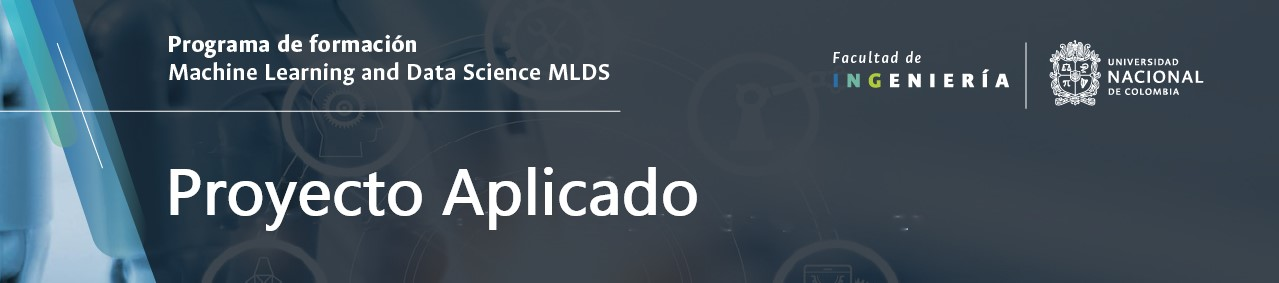

**Importar *librerías* a utilizar**

In [ ]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import keras
import sklearn

import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
!python --version
print('Pandas', pd.__version__)
print('NumPy', np.__version__)
print('Matplotlib', mpl.__version__)
print('missingno', msno.__version__)

Python 3.10.11
Pandas 1.5.3
NumPy 1.22.4
Matplotlib 3.7.1
missingno 0.5.2


Este material fue realizado con las siguientes versiones:

- Python: 3.10.11
- pandas: 1.5.3
- NumPy: 1.22.4
- Matplotlib: 3.7.1
- Missingno: 0.5.2

# **Mejorando el modelo, con la similitud de coseno**
---

## **3. Particion del conjunto de datos**
---

Vamos a preparar el *dataset* para el modelado. Nuestro objetivo es entrenar un **modelo autorregresivo**, en el cual el valor de la serie de tiempo en un momento dado $X_i$ depende de los $k$ valores anteriores.

La red neuronal debe tener $k$ entradas o *features* y $1$ salida, que corresponde al valor actual. Las *features* serán las $k$ observaciones previas, que corresponden a una **ventana** de tamaño $k$.

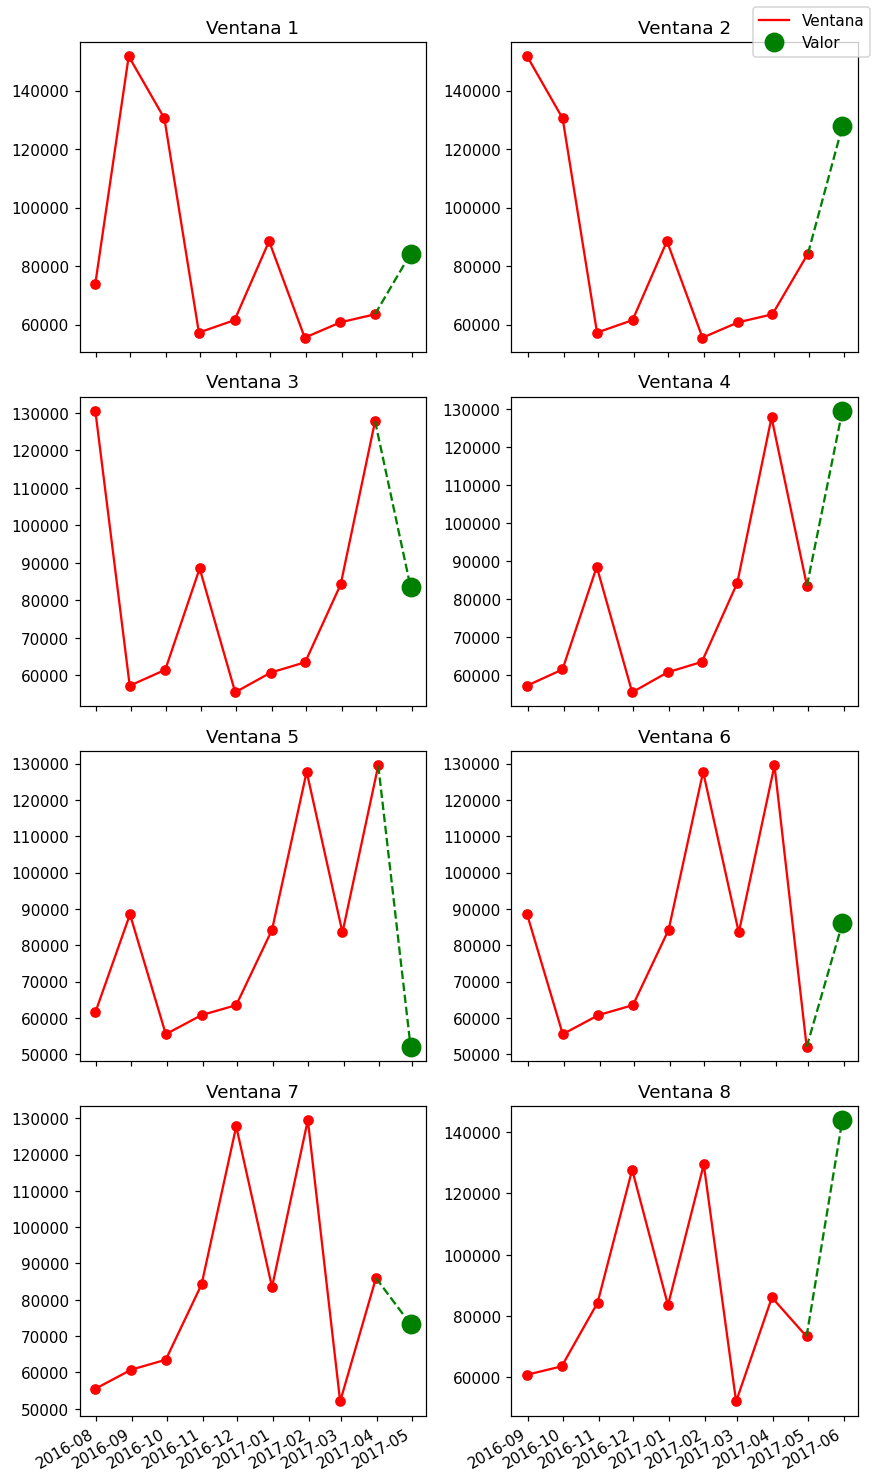

In [ ]:
#@markdown **Visualización:** Ventanas de tiempo.

#@markdown * **`n`**: Número de ventanas a visualizar.
n =   9#@param {type:"integer"}
#Visualización del concepto de ventana

#@markdown * **`k`**: Tamaño de la ventana.
k =   10#@param {type:"integer"}

fig, axes = plt.subplots(nrows = n//2, ncols= 2,  figsize = (8, 1.5*n), dpi = 110)

for i, ax in enumerate(axes.flat):
  data =  serie_ventas.iloc[i: i + k]
  ax.set_title(f'Ventana {i + 1}')
  ax.plot(data.index[:-1], data.values[:-1], 'r')
  ax.plot(data.index[-1], data.values[-1], 'go', ms = 12)
  ax.plot(data.index[:-1], data.values[:-1], 'ro')
  ax.plot(data.index[-2:], data.values[-2:], 'g--')
  fig.autofmt_xdate()
fig.tight_layout()

fig.legend(['Ventana', 'Valor']);

Para generar nuestro modelo vamos a iniciar con una ventana de tiempo de  6  observaciones.

## **3.1. Normalización de los datos**
---

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Realizaremos la normalización de los datos

serie_ventas = np.array(serie_ventas)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(serie_ventas.reshape(-1, 1))

In [ ]:
from sklearn.model_selection import train_test_split

# Realizamos la partición de los conjuntos de entrenamiento (60%), validación  (20%)y prueba (20%).

train_data, test_data = train_test_split(scaled_data, test_size=0.4, shuffle=False)
val_data, test_data = train_test_split(test_data, test_size=0.5, shuffle=False)

In [ ]:
# Tamaño de ventana o entrada del modelo

k = 6

# Número de meses a predecir o Salidas del modelo.

n_meses = 1


In [ ]:
# Creación de ventanas

def crear_ventanas(data, window_size, n_steps):
    X, y = [], []
    for i in range(len(data) - window_size - n_steps + 1):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size:i+window_size+n_steps])
    return np.array(X), np.array(y)

In [ ]:
X_train, y_train = crear_ventanas(train_data, k, n_meses)
X_val, y_val = crear_ventanas(val_data, k, n_meses)
X_test, y_test = crear_ventanas(test_data, k, n_meses)

In [ ]:
print(f'Datos:\n {X_train[0].flatten()}')
print(f'Predicción:\n{y_train[0]}')

Datos:
 [0.32628798 0.73712021 0.62483487 0.23778071 0.26023778 0.40290621]
Predicción:
[[0.22853369]]


In [ ]:
# Información sobre los conjuntos particionados.

print(f'Set de entrenamiento: {X_train.shape}, y_train: {y_train.shape}')
print(f'Set de validación: {X_val.shape}, y_val: {y_val.shape}')
print(f'Set de prueba: {X_test.shape}, y_test: {y_test.shape}')

Set de entrenamiento: (46, 6, 1), y_train: (46, 1, 1)
Set de validación: (12, 6, 1), y_val: (12, 1, 1)
Set de prueba: (12, 6, 1), y_test: (12, 1, 1)


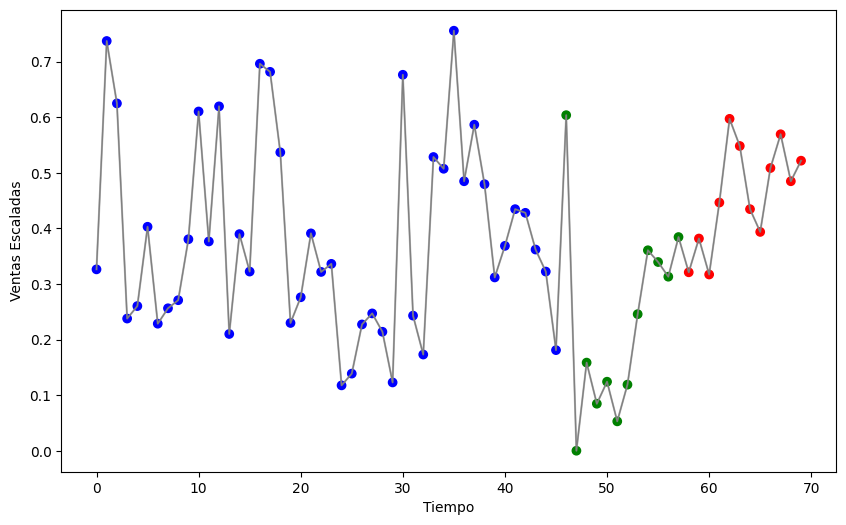

In [ ]:
# Visualizamos los conjuntos de datos

combined_data = np.concatenate((X_train, X_val, X_test), axis=0)
combined_labels = np.concatenate((y_train, y_val, y_test), axis=0)

total_data_points = combined_data.shape[0]

colors = ['blue'] * len(X_train) + ['green'] * len(X_val) + ['red'] * len(X_test)

plt.figure(figsize=(10, 6))
plt.plot(range(total_data_points), combined_data[:, 0, 0], color='gray', alpha=0.5)
plt.scatter(range(total_data_points), combined_data[:, 0, 0], c=colors)
plt.plot(range(total_data_points), combined_data[:, 0, 0], color='gray', linewidth=1)
plt.xlabel('Tiempo')
plt.ylabel('Ventas Escaladas')
plt.show()

## **3.2. Selección y diseño de modelos**
---

Basándonos en el conjunto de datos disponible, hemos determinado que el modelo más adecuado para abordar el problema que se nos presenta es un modelo de regresión. Las entradas de nuestro modelo estarán basadas en las ventas históricas mensuales de un producto específico del portafolio de la compañia, lo que implica que se trata de una serie de tiempo.

Dado lo anterior, hemos seleccionado una red neuronal recurrente LSTM para implementar en nuestro modelo. Esta elección se basa en la capacidad de las redes LSTM para manejar series de tiempo y predecir patrones de manera precisa. Con esta elección, esperamos obtener predicciones precisas y útiles que nos permitan tomar decisiones con información más precisa.

In [ ]:
# Definimos la arquitectura del modelo

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.activations import tanh

input_shape = (k, n_meses)
hidden_units = 64

input_layer = Input(shape=input_shape)
lstm_layer1 = LSTM(hidden_units, activation='tanh', return_sequences=True)(input_layer)
lstm_layer2 = LSTM(hidden_units, activation='tanh')(lstm_layer1)
output_layer = Dense(n_meses)(lstm_layer2)

model = Model(inputs=input_layer, outputs=output_layer)

En este modelo se utilizan dos capas de LSTM para mejorar la capacidad de aprendizaje de la red neuronal y capturar patrones complejos en la serie temporal.

La primera capa LSTM devuelve una secuencia completa de salidas para cada paso de tiempo en la serie temporal, que luego se utiliza como entrada para la segunda capa LSTM. La segunda capa LSTM produce una única salida que se alimenta a la capa de salida Dense, que predice la venta en el siguiente paso de tiempo.

Al utilizar dos capas LSTM, la red neuronal puede aprender a representar patrones complejos en la serie temporal. La primera capa LSTM puede capturar patrones a nivel local, mientras que la segunda capa LSTM puede aprender patrones a nivel global. Esto puede aumentar la precisión del modelo al predecir la venta en el siguiente paso de tiempo en la serie temporal.

In [ ]:
# Visualización del modelo

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 6, 1)]            0         
                                                                 
 lstm_4 (LSTM)               (None, 6, 64)             16896     
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


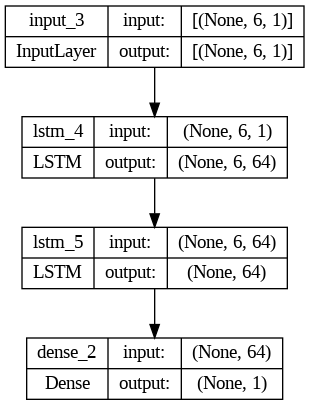

In [ ]:
# visualización diagramática del modelo

tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# Realizamos la compilación del modelo

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

optimizer = Adam(learning_rate=0.001)
loss = tf.losses.mse

model.compile(optimizer=optimizer,
              loss=loss
              )

model.get_compile_config()

{'optimizer': {'module': 'keras.optimizers',
  'class_name': 'Adam',
  'config': {'name': 'Adam',
   'weight_decay': None,
   'clipnorm': None,
   'global_clipnorm': None,
   'clipvalue': None,
   'use_ema': False,
   'ema_momentum': 0.99,
   'ema_overwrite_frequency': None,
   'jit_compile': True,
   'is_legacy_optimizer': False,
   'learning_rate': 0.0010000000474974513,
   'beta_1': 0.9,
   'beta_2': 0.999,
   'epsilon': 1e-07,
   'amsgrad': False},
  'registered_name': None},
 'loss': {'module': 'keras.losses',
  'class_name': 'function',
  'config': 'mean_squared_error',
  'registered_name': 'mean_squared_error'},
 'metrics': None,
 'loss_weights': None,
 'weighted_metrics': None,
 'run_eagerly': None,
 'steps_per_execution': None,
 'jit_compile': None}

In [ ]:
# Definición de los callbacks

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint('best_model.h5',
                             save_best_only=True,
                             monitor='val_loss',
                             mode='min',
                             verbose=1)
early_stopping = EarlyStopping(monitor='val_loss',
                               mode='min',
                               patience=30,
                               verbose=1)

In [ ]:
# Entrenamiento del modelo

history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, early_stopping]
                    )

Epoch 1/100
1/3 [=========>....................] - ETA: 6s - loss: 0.1199
Epoch 1: val_loss improved from inf to 0.04272, saving model to best_model.h5
3/3 [==============================] - 4s 351ms/step - loss: 0.1539 - val_loss: 0.0427
Epoch 2/100
1/3 [=========>....................] - ETA: 0s - loss: 0.0681
Epoch 2: val_loss improved from 0.04272 to 0.02316, saving model to best_model.h5
3/3 [==============================] - 0s 29ms/step - loss: 0.1007 - val_loss: 0.0232
Epoch 3/100
1/3 [=========>....................] - ETA: 0s - loss: 0.0709
Epoch 3: val_loss improved from 0.02316 to 0.01450, saving model to best_model.h5
3/3 [==============================] - 0s 29ms/step - loss: 0.0602 - val_loss: 0.0145
Epoch 4/100
1/3 [=========>....................] - ETA: 0s - loss: 0.0299
Epoch 4: val_loss did not improve from 0.01450
3/3 [==============================] - 0s 18ms/step - loss: 0.0401 - val_loss: 0.0233
Epoch 5/100
1/3 [=========>....................] - ETA: 0s - loss: 0.0

In [ ]:
# Evaluar el modelo en el conjunto de prueba

mse = model.evaluate(X_test, y_test)
print("MSE:", mse)


1/1 [==============================] - 0s 22ms/step - loss: 0.0163
MSE: 0.016340788453817368


In [ ]:
# Cargar el mejor modelo
model.load_weights('best_model.h5')

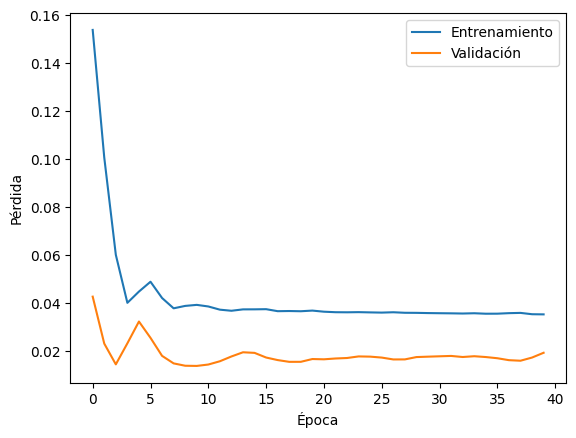

In [ ]:
# Graficar la pérdida durante el entrenamiento
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [ ]:
# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)
print(y_pred)

1/1 [==============================] - 1s 588ms/step
[[0.34846586]
 [0.3644227 ]
 [0.37089324]
 [0.38432908]
 [0.38973233]
 [0.38143203]
 [0.37888736]
 [0.38046348]
 [0.37268543]
 [0.3670472 ]
 [0.35960105]
 [0.3573529 ]]


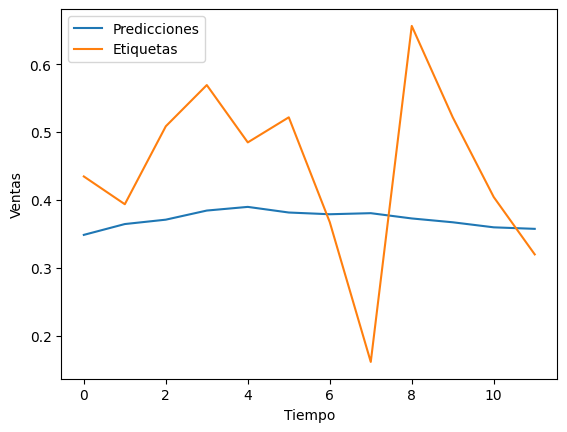

In [ ]:
# Graficar las predicciones y las etiquetas
plt.plot(y_pred.flatten(), label='Predicciones')
plt.plot(y_test.flatten(),label='Etiquetas')
plt.xlabel('Tiempo')
plt.ylabel('Ventas')
plt.legend()
plt.show()

In [ ]:
# Métricas de rendimiento
# Error absoluto, cuadrado, y cuadrado logarítmico.
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error

y_pred = model.predict(X_test)

y_test = np.reshape(y_test, (-1, 1))
y_pred = np.reshape(y_pred, (-1, 1))

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
msle = mean_squared_log_error(y_test, y_pred)

print(f"Test Mean Squared Error: \t{mean_squared_error(y_test, y_pred):.4f}")
print(f"Test Mean Absolute Error: \t{mean_absolute_error(y_test, y_pred):.4f}")
print(f"Test Mean squared log error: \t{mean_squared_log_error(y_test, y_pred):.4f}")

1/1 [==============================] - 0s 20ms/step
Test Mean Squared Error: 	0.0205
Test Mean Absolute Error: 	0.1188
Test Mean squared log error: 	0.0101


In [ ]:
# Desnormalizar las predicciones y las etiquetas
y_pred = scaler.inverse_transform(y_pred.reshape(-1, n_meses))
y_test = scaler.inverse_transform(y_test.reshape(-1, n_meses))

In [ ]:
print(y_pred)

[[78197.164]
 [81216.99 ]
 [82441.55 ]
 [84984.27 ]
 [86006.84 ]
 [84436.01 ]
 [83954.43 ]
 [84252.71 ]
 [82780.72 ]
 [81713.68 ]
 [80304.5  ]
 [79879.04 ]]


Dado los resultados anteriores de la red neuronal recurrente (RNN), vamos a definir una función de costo que penalice la falta de estructura y observaremos los resultados obtenidos.

La función de coste que utilizaremos tiene como objetivo medir la discrepancia entre la salida de la RNN y la estructura deseada. Penalizará aquellos casos en los que la salida no siga un patrón o no se ajuste adecuadamente a la estructura esperada.

Una vez definida esta función de coste, procederemos a evaluar los resultados de la RNN. Analizaremos cómo se comporta la red en términos de estructura y compararemos los resultados con nuestras expectativas.

Esta evaluación nos permitirá determinar si la RNN está aprendiendo correctamente la estructura deseada y si la función de coste está cumpliendo su propósito de penalizar la falta de estructura. A partir de estos resultados, podremos realizar ajustes y mejoras en el modelo, si es necesario.

In [ ]:
# Definimos la arquitectura del modelo

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.activations import tanh

input_shape = (k, n_meses)
hidden_units = 64

input_layer = Input(shape=input_shape)
lstm_layer1 = LSTM(hidden_units, activation='tanh', return_sequences=True)(input_layer)
lstm_layer2 = LSTM(hidden_units, activation='tanh')(lstm_layer1)
output_layer = Dense(n_meses)(lstm_layer2)

model = Model(inputs=input_layer, outputs=output_layer)

In [ ]:
import tensorflow.keras.backend as K

def cosine_similarity_loss(y_true, y_pred):
    y_true_normalized = K.l2_normalize(y_true, axis=-1)
    y_pred_normalized = K.l2_normalize(y_pred, axis=-1)
    similarity = K.sum(y_true_normalized * y_pred_normalized, axis=-1)
    cosine_similarity_loss = 1 - similarity
    return cosine_similarity_loss

In [ ]:
# Realizamos la compilación del modelo

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

optimizer = Adam(learning_rate=0.001)
loss = tf.losses.mse

model.compile(optimizer=optimizer,
              loss=cosine_similarity_loss
              )

model.get_compile_config()

{'optimizer': {'module': 'keras.optimizers',
  'class_name': 'Adam',
  'config': {'name': 'Adam',
   'weight_decay': None,
   'clipnorm': None,
   'global_clipnorm': None,
   'clipvalue': None,
   'use_ema': False,
   'ema_momentum': 0.99,
   'ema_overwrite_frequency': None,
   'jit_compile': True,
   'is_legacy_optimizer': False,
   'learning_rate': 0.0010000000474974513,
   'beta_1': 0.9,
   'beta_2': 0.999,
   'epsilon': 1e-07,
   'amsgrad': False},
  'registered_name': None},
 'loss': {'module': '__main__',
  'class_name': 'function',
  'config': 'cosine_similarity_loss',
  'registered_name': 'cosine_similarity_loss'},
 'metrics': None,
 'loss_weights': None,
 'weighted_metrics': None,
 'run_eagerly': None,
 'steps_per_execution': None,
 'jit_compile': None}

In [ ]:
# Definición de los callbacks

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint('best_model.h5',
                             save_best_only=True,
                             monitor='val_loss',
                             mode='min',
                             verbose=1)
early_stopping = EarlyStopping(monitor='val_loss',
                               mode='min',
                               patience=30,
                               verbose=1)

In [ ]:
# Entrenamiento del modelo

history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, early_stopping]
                    )

Epoch 1/100
1/3 [=========>....................] - ETA: 6s - loss: 2.0000
Epoch 1: val_loss improved from inf to 2.00000, saving model to best_model.h5
3/3 [==============================] - 4s 362ms/step - loss: 1.7391 - val_loss: 2.0000
Epoch 2/100
1/3 [=========>....................] - ETA: 0s - loss: 2.0000
Epoch 2: val_loss did not improve from 2.00000
3/3 [==============================] - 0s 17ms/step - loss: 2.0000 - val_loss: 2.0000
Epoch 3/100
1/3 [=========>....................] - ETA: 0s - loss: 2.0000
Epoch 3: val_loss did not improve from 2.00000
3/3 [==============================] - 0s 17ms/step - loss: 2.0000 - val_loss: 2.0000
Epoch 4/100
1/3 [=========>....................] - ETA: 0s - loss: 2.0000
Epoch 4: val_loss did not improve from 2.00000
3/3 [==============================] - 0s 17ms/step - loss: 2.0000 - val_loss: 2.0000
Epoch 5/100
1/3 [=========>....................] - ETA: 0s - loss: 2.0000
Epoch 5: val_loss did not improve from 2.00000
3/3 [==============

In [ ]:
# Evaluar el modelo en el conjunto de prueba

mse = model.evaluate(X_test, y_test)
print("MSE:", mse)

1/1 [==============================] - 0s 27ms/step - loss: 4.9671e-09
MSE: 4.967053879312289e-09


In [ ]:
# Cargar el mejor modelo
model.load_weights('best_model.h5')

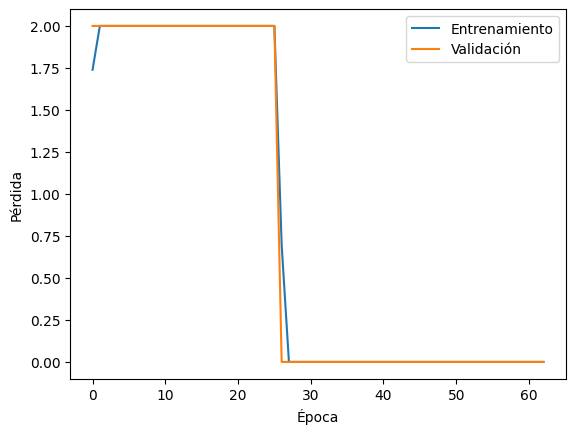

In [ ]:
# Graficar la pérdida durante el entrenamiento
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [ ]:
# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)
print(y_pred)

1/1 [==============================] - 1s 622ms/step
[[0.05844706]
 [0.05906585]
 [0.05931845]
 [0.0599672 ]
 [0.06025233]
 [0.05984538]
 [0.05970966]
 [0.05974136]
 [0.05943557]
 [0.05933806]
 [0.05898775]
 [0.05881604]]


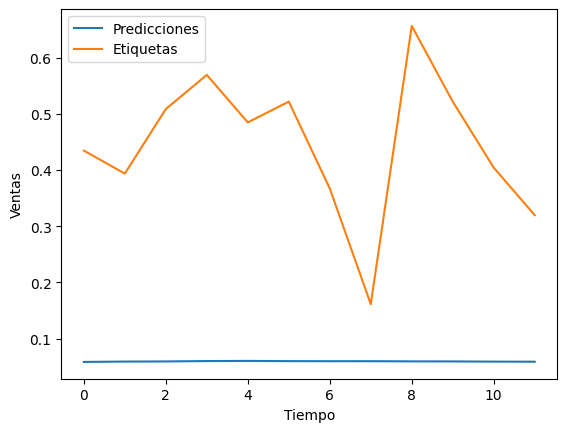

In [ ]:
# Graficar las predicciones y las etiquetas
plt.plot(y_pred.flatten(), label='Predicciones')
plt.plot(y_test.flatten(),label='Etiquetas')
plt.xlabel('Tiempo')
plt.ylabel('Ventas')
plt.legend()
plt.show()

Es evidente que los resultados obtenidos no cumplen con las expectativas esperadas.

Para el proyecto en cuestión, se propone realizar una búsqueda exhaustiva de hiperparámetros mediante el método de GridSearch con el fin de mejorar aún más el modelo. Sin embargo, es importante tener en cuenta que debido a limitaciones de GPU, no se pudo ejecutar el código en el notebook. A continuación, se detallará el procedimiento que se habría seguido para llevar a cabo esta búsqueda:

Definición de los hiperparámetros: En primer lugar, se identificaron los hiperparámetros del modelo que se deseaban optimizar, como la tasa de aprendizaje, el número de capas ocultas, la función de activación, el tamaño del lote, entre otros.

Definición del rango de búsqueda: Se estableció un rango de valores para cada hiperparámetro que se consideró relevante. Este rango debía ser lo suficientemente amplio para explorar diversas configuraciones, pero al mismo tiempo, debía tener en cuenta las limitaciones computacionales.

Creación de la tabla de búsqueda: Se generó una tabla de búsqueda que contenía todas las combinaciones posibles de valores de hiperparámetros dentro de los rangos establecidos. Cada combinación representaba una configuración única del modelo.

Entrenamiento y validación del modelo: Para cada configuración de hiperparámetros en la grilla de búsqueda, se habría realizado el entrenamiento del modelo utilizando los datos de entrenamiento y se habría evaluado su rendimiento utilizando los datos de validación. Se habría utilizado una métrica de evaluación adecuada para comparar y seleccionar los mejores modelos.

Selección del mejor modelo: Una vez finalizada la búsqueda exhaustiva, se habría seleccionado el modelo que obtuvo el mejor rendimiento según la métrica establecida. Se habría tenido en cuenta tanto el rendimiento en los datos de entrenamiento como en los datos de validación para evitar problemas de sobreajuste.

Evaluación del modelo final: Para obtener una estimación más realista del rendimiento del modelo seleccionado, se habría evaluado utilizando un conjunto de datos independiente, como un conjunto de prueba o un conjunto de validación final.

In [ ]:
from sklearn.model_selection import GridSearchCV

# Definir la función para crear el modelo
def create_model(hidden_units, activation, learning_rate, epochs, batch_size, patience, k):
    input_layer = Input(shape=input_shape)
    lstm_layer1 = LSTM(hidden_units, activation=activation, return_sequences=True)(input_layer)
    lstm_layer2 = LSTM(hidden_units, activation=activation)(lstm_layer1)
    output_layer = Dense(n_meses)(lstm_layer2)
    model = Model(inputs=input_layer, outputs=output_layer)
    optimizer = Adam(learning_rate=learning_rate)
    loss = MeanSquaredError()
    model.compile(optimizer=optimizer, loss=loss)
    return model


In [ ]:
# Definir los hiperparámetros y el espacio de búsqueda
param_grid = {
    'hidden_units': [32, 64, 128],
    'activation': ['tanh', 'relu'],
    'learning_rate': [0.001, 0.01, 0.1],
    'epochs': [50, 100, 200],
    'batch_size': [16, 32, 64],
    'patience': [10, 20, 30],
    'k': [4, 6, 8]  # Tamaño de la ventana
}

In [ ]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

# Realizar la búsqueda de hiperparámetros
model = KerasRegressor(build_fn=create_model)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_search.fit(X_train, y_train)

In [ ]:
# Obtener los mejores hiperparámetros y el mejor modelo
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [ ]:
# Evaluar el modelo en el conjunto de prueba
loss = best_model.score(X_test, y_test)